# Вебинар 6. Двухуровневые модели рекомендаций


# Import libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from catboost import CatBoostClassifier, Pool

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

## Read data

In [2]:
data = pd.read_csv('./lessons/web2/retail_train.csv')
item_features = pd.read_csv('./lessons/web2/product.csv')
user_features = pd.read_csv('./lessons/web2/hh_demographic.csv')

# Process features dataset

In [3]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'
ACTUAL_COL = 'actual'

In [4]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# Split dataset for train, eval, test

In [5]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)

VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [6]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]

# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [7]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [8]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [9]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


# Prefilter items

In [10]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

c:\Users\konst\Repo\education\gb_recommender_systems\utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))
Decreased # items from 83685 to 5001


# Make cold-start to warm-start

In [11]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (861404, 13) Users: 2495 Items: 5001
val_matcher
Shape: (169615, 12) Users: 2151 Items: 27644
train_ranker
Shape: (169615, 12) Users: 2151 Items: 27644
val_ranker
Shape: (118282, 12) Users: 2040 Items: 24325


# Init/train recommender

In [12]:
# als_params = None
als_params = {
    'factors': 128,
    'regularization': 0.05,
    'iterations': 10,
    'num_threads': 4,
}

recommender = MainRecommender(data_train_matcher, weighting_type='tfidf', als_params=als_params)

100%|██████████| 5001/5001 [00:00<00:00, 25708.90it/s]


# Eval recall of matching

In [13]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [14]:
def evalRecall(df_result: pd.DataFrame, target_col_name: str, result_col_name: str, recommend_model: MainRecommender, N: int, actual_col: str, N_predict: int):
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=N))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[actual_col], k=N_predict), axis=1).mean()

result_params: dict = {
    'own_rec': recommender.get_own_recommendations,
    'sim_item_rec': recommender.get_similar_items_recommendation,
    # 'sim_user_rec': recommender.get_similar_users_recommendation,
    'tfidf_rec': recommender.get_tfidf_recommendations,
    'cosine_rec': recommender.get_cosine_recommendations,
    'als_rec': recommender.get_als_recommendations,
}

# N = Neighbors
N_PREDICT = 50

for rec_name, rec_model in result_params.items():
    result = evalRecall(result_eval_matcher, USER_COL, rec_name, rec_model, 25, ACTUAL_COL, N_PREDICT)
    print('{}={}'.format(rec_name, result))

own_rec=0.03247640940823699
sim_item_rec=0.022180495444091165
tfidf_rec=0.0693253113171965
cosine_rec=0.0676801154187011
als_rec=0.053896537704620676


    bm25
    ----
    own_rec=0.0441195473958354
    sim_item_rec=0.019855746040557797
    tfidf_rec=0.05081053405831492
    cosine_rec=0.04221593077869987

    als_rec=0.033331734651510986 (default ALS params)
    als_rec=0.048982775644030245 (optimized ALS params)

    tfidf
    ----
    own_rec=0.03247640940823699
    sim_item_rec=0.01968387790837418
    tfidf_rec=0.0693253113171965
    cosine_rec=0.0676801154187011

    als_rec=0.04237601076260919 (default ALS params)
    als_rec=0.053494135108441816 (optimized ALS params)

## Best results is `tfidf_rec=0.069`: `weight_type='tfidf'`

In [15]:
def calc_recall(df_data: pd.DataFrame, top_k: int, actual_col: str):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[actual_col], k=top_k), axis=1).mean()

In [16]:
def calc_precision(df_data: pd.DataFrame, top_k: int, actual_col: str):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[actual_col], k=top_k), axis=1).mean()

### Recall@50 of matching

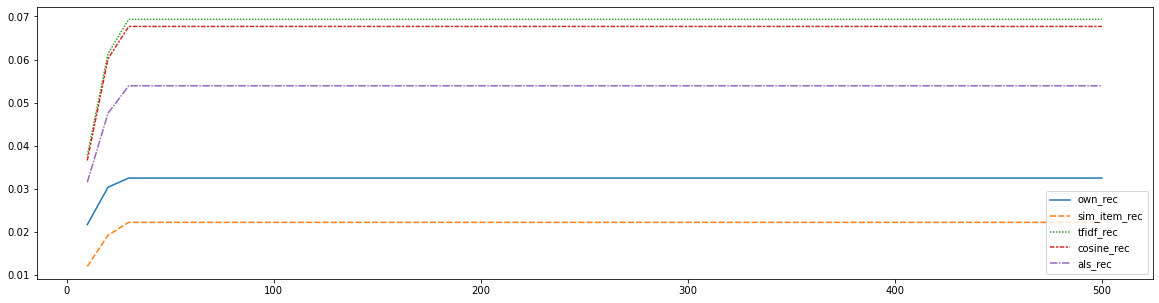

In [17]:
results_recall = dict()
for k in range(10, 510, 10):
    gen = calc_recall(result_eval_matcher, k, ACTUAL_COL)
    for itm in gen:
        if k not in results_recall:
            results_recall[k] = dict()
        results_recall[k].update({itm[0]: itm[1]})

plt.figure(figsize=(20, 5))
sns.lineplot(data=pd.DataFrame.from_dict(results_recall, orient='index'))

In [18]:
pd.DataFrame.from_dict(results_recall, orient='index').sort_values(by='tfidf_rec', ascending=False).head()

,own_rec,sim_item_rec,tfidf_rec,cosine_rec,als_rec
260,0.032476,0.02218,0.069325,0.06768,0.053897
270,0.032476,0.02218,0.069325,0.06768,0.053897
290,0.032476,0.02218,0.069325,0.06768,0.053897
300,0.032476,0.02218,0.069325,0.06768,0.053897
310,0.032476,0.02218,0.069325,0.06768,0.053897


In [19]:
results_recall[50]

{'own_rec': 0.03247640940823699,
 'sim_item_rec': 0.022180495444091165,
 'tfidf_rec': 0.0693253113171965,
 'cosine_rec': 0.0676801154187011,
 'als_rec': 0.053896537704620676}

### При значении k>50 recal уже не меняется

In [20]:
TOPK_RECALL = 50

### Precision@5 of matching

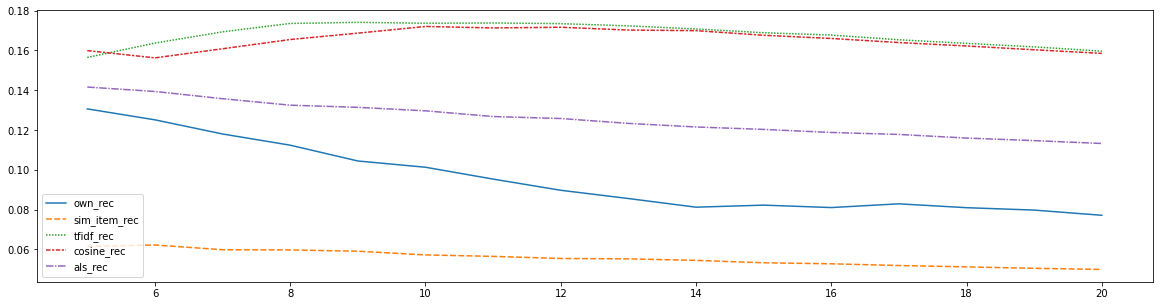

In [21]:
results_precision = dict()
for k in range(5, 21, 1):
    gen = calc_precision(result_eval_matcher, k, ACTUAL_COL)
    for itm in gen:
        if k not in results_precision:
            results_precision[k] = dict()
        results_precision[k].update({itm[0]: itm[1]})

plt.figure(figsize = (20, 5))
sns.lineplot(data=pd.DataFrame.from_dict(results_precision, orient='index'))

In [22]:
pd.DataFrame.from_dict(results_precision, orient='index').sort_values(by='tfidf_rec', ascending=False).head()

,own_rec,sim_item_rec,tfidf_rec,cosine_rec,als_rec
9,0.104448,0.059094,0.174131,0.168707,0.131412
11,0.095347,0.056506,0.173830,0.171337,0.126791
10,0.101302,0.057229,0.173687,0.172060,0.129661
8,0.112390,0.059740,0.173582,0.165504,0.132497
12,0.089726,0.055439,0.173485,0.171664,0.125794


In [23]:
TOPK_PRECISION = 9

# Ranking part

## Prepare data

In [24]:
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [25]:
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_tfidf_recommendations(x, N=N_PREDICT))

In [26]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[844179, 1029743, 916122, 866211, 1044078, 112..."
1,2021,"[844179, 1044078, 916122, 866211, 1119454, 102..."


In [27]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [28]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [29]:
df_match_candidates.head(4)

,user_id,item_id
0,2070,844179
0,2070,1029743
0,2070,916122
0,2070,866211


### Check warm start

In [30]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (107550, 2) Users: 2151 Items: 4976


### Create train data set for ranking

In [47]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')
df_ranker_train['target'].fillna(0, inplace= True)

df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

In [31]:
df_ranker_train.target.value_counts()

0.0    95421
1.0    18620
Name: target, dtype: int64

In [32]:
df_ranker_train.head(2)

,user_id,item_id,target
0,2070,844179,0.0
1,2070,1029743,0.0


In [127]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [128]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [54]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
7,2375,26984851516,1,1085983,1,2.99,364,-0.4,1642,1,0.0,0.0,2.99
11,1364,26984896261,1,999999,1,2.19,31742,0.0,1520,1,0.0,0.0,2.19


## Prepare features

In [56]:


print_stats_data(df_ranker_train, 'before featurizing')

########## user_id

# Средний чек
data_train_matcher_user_group = data_train_matcher[['user_id', 'quantity', 'price']].groupby(['user_id'], as_index=False)\
    .agg({
        'price': 'mean',
    })\
    .rename(columns={
        'price': 'avg_bill',
    })
df_ranker_train = df_ranker_train.merge(data_train_matcher_user_group[['user_id', 'avg_bill']], on='user_id', how='left')

# Средний чек по категории
avg_bill_by_dep_group = df_ranker_train[['department', 'avg_bill']].groupby(['department'], as_index=False)\
    .agg({'avg_bill': 'mean'})\
    .rename(columns={'avg_bill': 'avg_bill_by_dep'})
df_ranker_train = df_ranker_train.merge(avg_bill_by_dep_group[['department', 'avg_bill_by_dep']], on='department', how='left')

########## item_id

# Среднее количество покупок товара в неделю
# Средняя цена товара
data_train_matcher_item_group = data_train_matcher[['item_id', 'quantity', 'week_no', 'price']].groupby(['item_id'], as_index=False)\
    .agg({
        'quantity': 'sum',
        'week_no': 'max',
        'price': 'mean',
    })\
    .rename(columns={
        'quantity': 'total_quantity',
        'week_no': 'max_week_no',
        'price': 'avg_price',
    })
df_ranker_train = df_ranker_train.merge(data_train_matcher_item_group[['item_id', 'total_quantity', 'max_week_no', 'avg_price']], on='item_id', how='left')

# Среднее количество покупок товара в неделю
df_ranker_train['avg_quantity_per_week'] = df_ranker_train['total_quantity'] / df_ranker_train['max_week_no']

# Цена / Средняя цена товара в категории
item_price_dep_avg_group = df_ranker_train[['department', 'avg_price']].groupby(['department'], as_index=False)\
    .agg({'avg_price': 'mean'})\
    .rename(columns={'avg_price': 'avg_dep_price'})
df_ranker_train = df_ranker_train.merge(item_price_dep_avg_group[['department', 'avg_dep_price']], on='department', how='left')
df_ranker_train['avg_price/avg_dep_price'] = df_ranker_train['avg_price'] / df_ranker_train['avg_dep_price']

# Убираем лишние категории
df_ranker_train.loc[df_ranker_train['kid_category_desc'] == 'None/Unknown', 'kid_category_desc'] = '-'
df_ranker_train.loc[df_ranker_train['homeowner_desc'] == 'Unknown', 'homeowner_desc'] = '-'
df_ranker_train.loc[df_ranker_train['hh_comp_desc'] == 'Unknown', 'hh_comp_desc'] = '-'
cat_feats = ['manufacturer', 'department', 'brand', 'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
             'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc', 'hh_comp_desc', 'household_size_desc',
             'kid_category_desc']

for feat in cat_feats:
    df_ranker_train[feat] = df_ranker_train[feat].fillna('-')
    df_ranker_train[feat] = df_ranker_train[feat].astype('category')

print_stats_data(df_ranker_train, 'after featurizing')

before featurizing
Shape: (114041, 16) Users: 2151 Items: 4976
after featurizing
Shape: (114041, 24) Users: 2151 Items: 4976


In [48]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,avg_bill,avg_bill_by_dep,avg_price,avg_quantity_per_week,avg_price/avg_dep_price
0,2070,844179,0.0,2852,MEAT,National,BEEF,PRIMAL,,45-54,...,50-74K,-,-,1,-,4.20884,4.117195,3.832766,49.364706,0.828802
1,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,...,50-74K,-,-,1,-,4.20884,4.095411,2.523331,132.658824,0.723703


In [49]:
df_ranker_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114041 entries, 0 to 114040
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   user_id                  114041 non-null  int64   
 1   item_id                  114041 non-null  int64   
 2   target                   114041 non-null  float64 
 3   manufacturer             114041 non-null  category
 4   department               114041 non-null  category
 5   brand                    114041 non-null  category
 6   commodity_desc           114041 non-null  category
 7   sub_commodity_desc       114041 non-null  category
 8   curr_size_of_product     114041 non-null  category
 9   age_desc                 114041 non-null  category
 10  marital_status_code      114041 non-null  category
 11  income_desc              114041 non-null  category
 12  homeowner_desc           114041 non-null  category
 13  hh_comp_desc             114041 non-null  ca

## Train ranking model

In [83]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

params_frozen = {
    'eval_metric': 'Accuracy',
    'early_stopping_rounds': 50,
}

# params_grid = {
#     'depth': [6, 8, 10],
#     'learning_rate': [0.03, 0.3, 0.5],
#     'iterations': [400, 800, 1200],
#     'l2_leaf_reg': [2, 3, 4],
#     'bagging_temperature': [1, 1.5, 2],
# }

train_pool = Pool(
    X_train,
    y_train,
    cat_features=cat_feats
)

# clf = CatBoostClassifier(**params_frozen)
# rs = clf.randomized_search(
#     params_grid,
#     train_pool,
#     n_iter=5,
#     partition_random_seed=0,
#     cv=5,
#     calc_cv_statistics=True,
#     search_by_train_test_split=True,
#     refit=True,
# )

clf = CatBoostClassifier(
    bagging_temperature=2,
    depth=8,
    l2_leaf_reg=2,
    iterations=400,
    learning_rate=0.3,
    verbose=False,
    **params_frozen
)
clf.fit(train_pool)

train_preds = clf.predict_proba(X_train)
df_ranker_predict = df_ranker_train.copy()
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

# Evaluation on test dataset

In [84]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


## Eval matching on test dataset

In [85]:
%%time
result_eval_ranker['tfidf_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_tfidf_recommendations(x, N=N_PREDICT))

Wall time: 23.7 s


## Eval re-ranked matched result on test dataset
    

In [86]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [87]:
result_eval_ranker['reranked_tfidf_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [88]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION, ACTUAL_COL), key=lambda x: x[1], reverse=True), sep='\n')

c:\Users\konst\Repo\education\gb_recommender_systems\metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)
('reranked_tfidf_rec', 0.18610966057441256)
('tfidf_rec', 0.14607843137254906)


    ----
    baseline
    ----
    ('own_rec', 0.14441176470588235)
    ('reranked_own_rec', 0.13681462140992168)
    
    ----
    + 0.0348: optimized recall
    ----
    ('reranked_tfidf_rec', 0.1792167101827676)
    ('tfidf_rec', 0.14607843137254906)

    ----
    + 0.0069: features item_id + user_id features
    ----
    ('reranked_tfidf_rec', 0.18610966057441256)
    ('tfidf_rec', 0.14607843137254906)